# Job Shop Scheduling
# with Randomized Optimization Algorithms (ROAs)


## 1. Preprocessing / Reading Instances
- Read a benchmark instance file
- Parse jobs and machines
- Verify format (machines indexing)


In [185]:
from pathlib import Path

path = Path("jobshop.txt") 
text = path.read_text(encoding="utf-8", errors="ignore")


In [186]:
instance = "bea20"

lines = text.splitlines()
start = None
for i, line in enumerate(lines):
    if line.strip().lower() == f"instance {instance}":
        start = i
        break

print("Start-row for instance:", start)
print("Rows after start :")
for k in range(start, start + 8):
    print(lines[k])


Start-row for instance: 2216
Rows after start :
 instance bea20
+++++++++++++++++++++++++++++
 20 20
 13 47 16 21 17 27  8 46  1 27 14 39 19 24  4 34  7 27  3 36  6 11  5 32  0 13  9 40  2 40 15 20 18 45 10 23 12 36 11 31  
  1 40 11 20 12 27  6 32 16 26 13 36 10 37  7 26  3 22  4 44 18 18  2 11 17 15  9 27 15 39  5 25  8 16 14 13  0 49 19 25  
  9 40  8 11 14 47  2 35 13 41  7 37  1 37 18 28  6 42  3 23 10 41  5 33 17 25  0 19 19 15 16 42 12 37 11 34  4 10 15 41  
  2 28  4 18 11 42  5 26 13 27  6 24 12 41  0 25  1 27  7 40 17 40 14 49 10 33  3 30 15 34 16 17  8 49  9 21 18 35 19 42  
  7 26  9 27  4 25  3 42 19 28 15 22 17 34  0 15  6 46  1 34 12 47  2 16 16 34 10 31 14 24  5 43 13 45 11 47  8 18 18 15  


In [187]:
j = start + 1

# skip empty/non-digit rows until we find two integers
while j < len(lines):
    parts = lines[j].split()
    if len(parts) >= 2 and parts[0].isdigit() and parts[1].isdigit():
        n_jobs, n_machines = int(parts[0]), int(parts[1])
        break
    j += 1

print("n_jobs =", n_jobs, "n_machines =", n_machines)


n_jobs = 20 n_machines = 20


In [188]:
jobs = []
j += 1 # go to first job line

for _ in range(n_jobs):
    nums = list(map(int, lines[j].split()))
    ops = [(nums[k], nums[k+1]) for k in range(0, len(nums), 2)]
    jobs.append(ops)
    j += 1

print("First job:", jobs[0])
print("Number of operations in first job:", len(jobs[0]))


First job: [(13, 47), (16, 21), (17, 27), (8, 46), (1, 27), (14, 39), (19, 24), (4, 34), (7, 27), (3, 36), (6, 11), (5, 32), (0, 13), (9, 40), (2, 40), (15, 20), (18, 45), (10, 23), (12, 36), (11, 31)]
Number of operations in first job: 20


### Create an initial solution

## 2. Representation (Solution Encoding)


In [189]:
import random

# number of operations per job
ops_per_job = [len(job) for job in jobs]

# build the "base list": job i is repeated as many times as it has operations
solution = []
for job_id, k in enumerate(ops_per_job):
    solution += [job_id] * k

random.shuffle(solution)

print("length of solution:", len(solution))
print("First 20:", solution[:36])


length of solution: 400
First 20: [19, 17, 0, 17, 3, 6, 7, 11, 17, 14, 4, 7, 7, 17, 16, 9, 16, 1, 1, 11, 17, 14, 9, 9, 10, 1, 13, 12, 19, 1, 8, 9, 10, 14, 6, 18]


## 3. Trajectory-based Algorithm: Simulated Annealing (SA)
- Neighbour generation (swap)
- Acceptance probability and temperature cooling
- Parameters: iters, T0, alpha


In [190]:
# Define a “neighbor” change
def swap_neighbor(sol):
    sol2 = sol[:] 
    i, j = random.sample(range(len(sol2)), 2)
    sol2[i], sol2[j] = sol2[j], sol2[i]
    return sol2

neighbor = swap_neighbor(solution)
print("Original (first 20):", solution[:36])
print("Neighbor  (first 20):", neighbor[:36])


Original (first 20): [19, 17, 0, 17, 3, 6, 7, 11, 17, 14, 4, 7, 7, 17, 16, 9, 16, 1, 1, 11, 17, 14, 9, 9, 10, 1, 13, 12, 19, 1, 8, 9, 10, 14, 6, 18]
Neighbor  (first 20): [19, 17, 0, 17, 3, 19, 7, 11, 17, 14, 4, 7, 7, 17, 16, 9, 16, 1, 1, 11, 17, 14, 9, 9, 10, 1, 13, 12, 19, 1, 8, 9, 10, 14, 6, 18]


In [191]:
def makespan_from_solution(solution, jobs, n_machines):

    n_jobs = len(jobs)

# initialize times: machines free at 0, jobs ready at 0, next operation index = 0
    machine_ready = [0] * n_machines
    job_ready = [0] * n_jobs
    next_op = [0] * n_jobs

    for j in solution:
        op_idx = next_op[j] # next operation index for this job
        m, t = jobs[j][op_idx]

        start = max(job_ready[j], machine_ready[m])
        finish = start + t

        job_ready[j] = finish
        machine_ready[m] = finish
        next_op[j] += 1

    return max(job_ready)   # makespan = last job to finish


In [192]:


ms = makespan_from_solution(solution, jobs, n_machines)
print("Makespan for one random solution:", ms)


Makespan for one random solution: 1832


In [193]:
import math

def simulated_annealing(jobs, n_machines, init_solution,
                       iters=5000, T0=200.0, alpha=0.995):
    current = init_solution[:]
    current_ms = makespan_from_solution(current, jobs, n_machines)

    best = current[:]
    best_ms = current_ms

    T = T0
    history = []

    for _ in range(iters):
        candidate = swap_neighbor(current)
        cand_ms = makespan_from_solution(candidate, jobs, n_machines)

        delta = cand_ms - current_ms  # <0 is better 
        if delta <= 0:
            accept = True
        else:
            accept_prob = math.exp(-delta / T) if T > 1e-12 else 0.0
            accept = (random.random() < accept_prob)

        if accept:
            current, current_ms = candidate, cand_ms
            if current_ms < best_ms:
                best, best_ms = current[:], current_ms
                
        # print("iter", _, "current_ms", current_ms, "best_ms", best_ms)
        history.append(best_ms)
        T *= alpha  # Cool down 
     
    return best, best_ms, history


In [194]:
best_sol, best_ms, history = simulated_annealing(jobs, n_machines, solution,
                                                 iters=5000, T0=100.0, alpha=0.995)
print("best makespan:", best_ms)


best makespan: 1145


## 4. Experiments & Visualizations
- Multiple runs to handle stochasticity
- Plots: best makespan over iterations
- Boxplot/summary over many runs


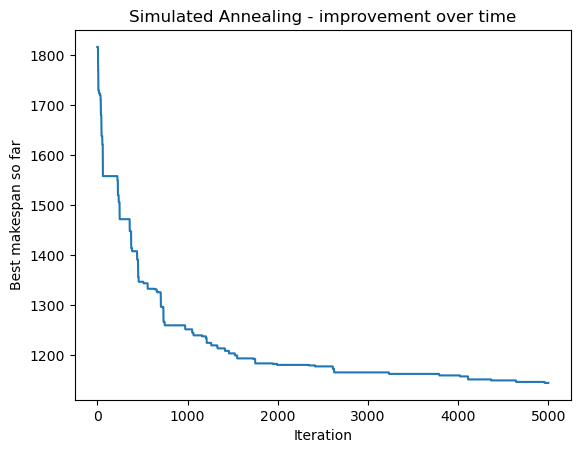

In [195]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best makespan so far")
plt.title("Simulated Annealing - improvement over time")
plt.show()


In [196]:
import numpy as np

runs = 10
best_values = []

for r in range(runs):
    # new random start
    sol0 = solution[:] 
    random.shuffle(sol0)

    _, best_ms_run, _ = simulated_annealing(jobs, n_machines, sol0, iters=150000, T0=100.0, alpha=0.995)
    best_values.append(best_ms_run)

arr = np.array(best_values)

print("Best makespan per run:",arr)
print("Min:", arr.min())
print("Mean:", arr.mean())
print("Std:", arr.std())



Best makespan per run: [973 971 976 955 989 950 937 943 964 987]
Min: 937
Mean: 964.5
Std: 16.948451256678293


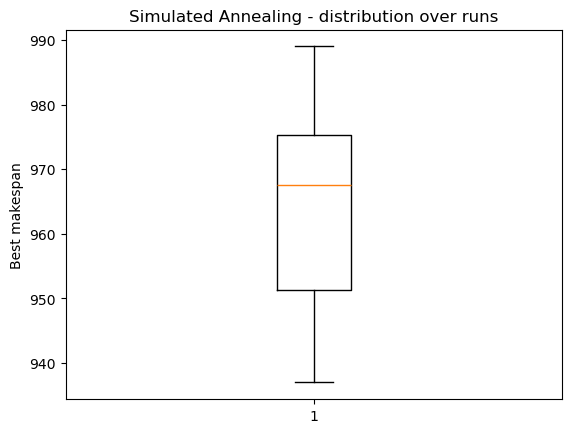

In [197]:
plt.figure()
plt.boxplot(best_values)
plt.ylabel("Best makespan")
plt.title("Simulated Annealing - distribution over runs")
plt.show()
